# Noise Filtering + Peak Finding approach for counting breaths


## In this notebook: 
- I first used a **low-pass filtering algorithm** to filter out noise from the accelerometer data. 

- After that, I counted the **number of peaks** in the filtered signal in order to calculate the bpm.

## Low-Pass Filter:

**Definition:** A [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) is a filter that passes signals with a frequency lower than a selected cutoff frequency and attenuates signals with frequencies higher than the cutoff frequency.

- For now, the **cutoff frequency** is set to 0.7 Hz. So, any signal above that frequency will be canceled out. (Humans have breathing rates that typically range from 0.2 to 0.4 Hz)

- I've put 125 Hz as the **sampling rate** in this algorithm for the time being as it was the most common sampling rate in the data acc. to the frequency density plot I created early on (see below).
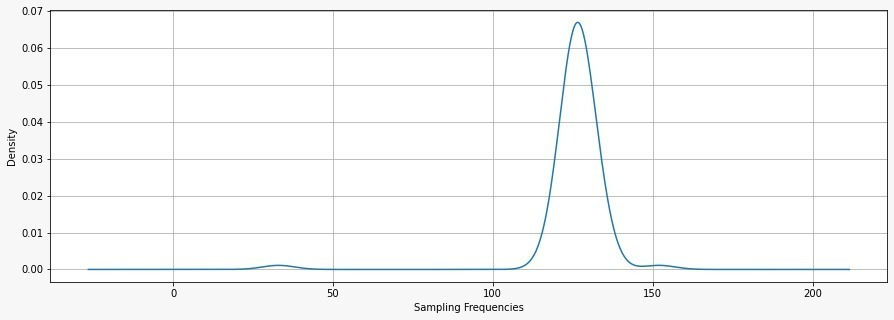

## Peak Finding:

After smoothing out the data using low pass filter, I simply counted the no. of peaks that are beyond the given amplitude threshold (for now, the threshold is 0.01)

## Method for calculating BPM:

$$
  \frac{No. Of Peaks In The Sample}{Time Period}×60
$$

## Idea for using this algorithm in real time data

- Run the smoothing+peak finding algorithm on all 3 axes and compare the bpm values
- If two axes have similar values (±1 to ±3 maybe, after taking into account any unexpected motion), then output the avg of those two values as the breathing rate value.
- Do this for a timeframe of 5-15 seconds (we can start with 5s initially for less buffer time, and increase the interval till we reach 10 or even 15s to improve accuracy)

## Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, freqz, find_peaks
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (20,13) # sets the figure size for every plot

## Load the dataframe

Upload the spreadsheet in files section to the left. For now, I've used [this](https://docs.google.com/spreadsheets/d/1kK6C7Q8jWkR75CWBmsnnMEsmC9U0Ezte/edit?usp=sharing&ouid=112941699617163336095&rtpof=true&sd=true) sample

In [ ]:
df = pd.read_excel('Maneeta_Calm_Abdomen_Flat.xlsx', index_col = 1)  # replace with the name of the file you want to use - if csv, change to function to pd.read_csv
df = df.drop('Unnamed: 0', axis=1)
df.columns = df.iloc[0]       # setting the index for columns
df = df[1:]                   # removed the first row because it was blank

# df['Timestamp'] = df['Timestamp']*0.000001

data = df['Accelerometer-Y']  # replace Y with any axis you want to use

## Low Pass Functions

In [ ]:
order = 6
fs = 125.0            # sample rate in Hz
cutOffFreq = 0.7      # desired cutoff frequency of the filter in Hz
peakThreshold = 0.01  # threshold for finding peaks

In [ ]:
def lowpass(cutOffFreq, fs, order=5):
    return butter(order, cutOffFreq, fs=fs, btype='low', analog=False)

def lowpassFilter(data, cutOffFreq, fs, order=5):
    b, a = lowpass(cutOffFreq, fs, order=order)
    y = lfilter(b, a, data)
    return y

## OPTIONAL: Check the [frequency response](https://en.wikipedia.org/wiki/Frequency_response).

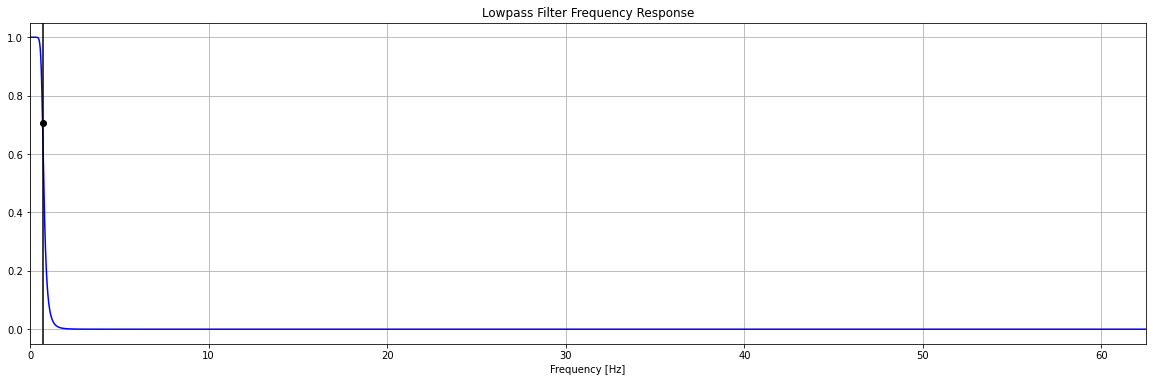

In [ ]:
#@title

b, a = lowpass(cutOffFreq, fs, order) # get the filter coefficients

# plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutOffFreq, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutOffFreq, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

## Define the characteristics of the data: no. of data points, time column

In [ ]:
# T = 5.0         # seconds
n = df.shape[0]   # no. of rows in the data
t = df.Timestamp  # time column

## Run the filtering algorithm

In [ ]:
# Filter the data
y = lowpassFilter(data, cutOffFreq, fs, order)

## Plotting filtered data alongside the original one

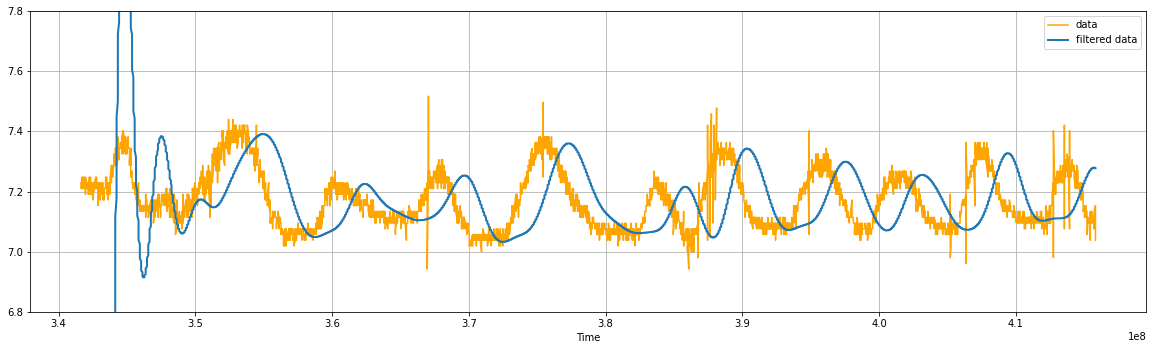

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(t, data, label='data', color='orange')
plt.plot(t, y, linewidth=2, label='filtered data')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
# plt.ylim(6.8,7.8)           # set ylim
# plt.xlim(3.5,4.1)           # set xlim
plt.show()

## Finding peaks

In [ ]:
peaks = find_peaks(y, height=peakThreshold)
# print(peaks)

noOfPeaks = len(peaks[1]['peak_heights'])

print(f'Number of peaks in this sample: {noOfPeaks}')

Number of peaks in this sample: 13


## Calculating BPM

In [ ]:
timeInterval = (df.Timestamp[-1]-df.Timestamp[0])*0.000001
breathingRate = round(noOfPeaks/timeInterval*60, 2)
print(f'Breaths Per Minute: {breathingRate}')

Breaths Per Minute: 10.51
